In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def ugraphs(scrobsdf, colname):
    scrobsM = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
    scrobsM[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf[colname]
    scrobsM = scrobsM.tocsr()

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    ax = fig.add_subplot(2,2,1)
    ax.set_xlabel("scrobbles")
    sns.histplot(scrobsM[1].data,ax=ax)
    for i in range(2,5):
        ax = fig.add_subplot(2, 2, i)
        ax.set_xlabel("scrobbles")
        sns.histplot(scrobsM[i+11].data, ax=ax)

    plt.show()

In [3]:
def topnart(scrobsdf, colname, n=10):
    artdf = pd.read_csv("./data/lastfm_artist_list.csv")
    artdf = artdf.set_index("artist_id")
    artists = artdf.to_numpy().flatten()
    artists = np.insert(artists,0,'___empty___')
    
    scrobsM = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
    scrobsM[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf[colname]
    scrobsM = scrobsM.tocsr()
    
    mask = (scrobsM.getnnz(axis=0) == 0)
    nnz = scrobsM.getnnz(axis=0)
    nnz[mask] = 1
    scores = scrobsM.sum(axis=0).A[0]#/nnz
    
    top50 = artists[scores.argsort()[::-1]][:n]
    scores.sort()
    scores = scores[::-1][:n]
    df = pd.DataFrame(np.array([top50,scores]).T, columns = ["artist", colname])
    return df

def artgraphs(scrobsdf):
    sp = topnart(scrobsdf,"scrobbles", 100)
    palette = dict(zip(sp.artist, sns.color_palette(n_colors=100)))
    s = topnart(scrobsdf,"scrobbles")
    r = topnart(scrobsdf,"rating")
    r1 = topnart(scrobsdf,"rating1")

#     s = s.merge(r,how="left",on="artist")
#     s = s.merge(r1,how="left",on="artist")
    fig = plt.figure(figsize=(10, 10), dpi=80)
    fig.subplots_adjust(hspace = .2, wspace = .6)
    ax = fig.add_subplot(2,2,1)
    ax.set_title("top 10 artists by scrobbles")
    sns.barplot(y=s.artist,x=s.scrobbles,ax=ax, palette = palette)
    
    ax = fig.add_subplot(2,2,2)
    ax.set_title("top 10 artists by rating")
    sns.barplot(y=r.artist,x=r.rating,ax=ax,palette = palette)
    
    ax = fig.add_subplot(2,2,3)
    ax.set_title("top 10 artists by rating1")
    
    sns.barplot(y=r1.artist,x=r1.rating1,ax=ax,palette = palette)

In [4]:
def ratgraphs(scrobsdf, nname):
    fig = plt.figure(figsize=(10, 10), dpi=80)
    fig.subplots_adjust(hspace = .5, wspace = .4)
    ax = fig.add_subplot(3,3,1)
    ax.set_xlabel("rating")
    ax.set_title("original")
    sns.histplot(scrobsdf[nname], ax=ax)

    ax = fig.add_subplot(3,3,2)
    ax.set_xlabel("rating")
    ax.set_title("log(x+0)")
    newrating = np.log(scrobsdf[nname])
    newrating += abs(min(newrating))
    patches = sns.histplot(newrating, ax=ax).patches
    ax.axvline(x=patches[np.argmax([x.get_height() for x in patches])].get_x(), color='red')
    for i in range(3,10):
        ax = fig.add_subplot(3, 3, i)
        ax.set_xlabel("rating")
        eps = 10**-(i/4)

        ax.set_title(f"log(x+{eps:0.3})")
        newrating = (np.log(scrobsdf[nname]+eps))
        newrating += abs(min(newrating))
        data = newrating
        _, bins, _ = plt.hist(data, 200, alpha=0.5, density=1)

        mu, sigma = stats.norm.fit(data)

        best_fit_line = stats.norm.pdf(bins, mu, sigma)

        ax.plot(bins, best_fit_line)

In [58]:
def recalc_ratings():
    scrobsdf = pd.read_csv("./udata/top_artists_smaller.csv")
    scrobsdf.columns = ["user_id", "artist_id", "scrobbles"]
    artdf = pd.read_csv("./udata/artistids.pcpsv", sep="\|,\|", engine="python", header=None)
    artdf.columns=["artist_id", "artist_name"]
    artdf = artdf.set_index("artist_id")
    
    artists = artdf.to_numpy().flatten()
    artists = np.insert(artists,0,'___empty___')
    
    scrobsdf["artist_name"] = artists[scrobsdf["artist_id"].to_numpy()]

    uscrobs = scrobsdf.groupby("user_id").scrobbles
    umin = uscrobs.transform('min').to_numpy()
    umax = uscrobs.transform('max').to_numpy()
    
    badusers2 = scrobsdf.iloc[(umax-umin) == 0].user_id.unique()
    scrobsdf = scrobsdf[~scrobsdf.user_id.isin(badusers2)]
    
    uscrobs = scrobsdf.groupby("user_id").scrobbles
    umin = uscrobs.transform('min').to_numpy()
    umax = uscrobs.transform('max').to_numpy()
    
    med = scrobsdf.scrobbles.median()
    umed = uscrobs.transform("median").to_numpy()
    
    adjust = umed/med # describes if user's top 50 shouold be highly rated, high -> overall high scores, low -> overall average scores
    spread = umax/umed # describes the desired spread of a user's scores, high -> big top low bottom score, low -> close together
    
    scrobsdf["norm"] = (scrobsdf.scrobbles)/(umax+umean)
    scrobsdf["rating"] = np.log(scrobsdf.norm+0.03)
    
    scrobsdf["norm1"] = ((scrobsdf.scrobbles)/(umax+umean) + ((adjust - adjust.min())/(adjust.max()-adjust.min())))
    scrobsdf["rating1"] = np.log(scrobsdf.norm1+0.03)
    
    scrobsdf.rating += abs(min(scrobsdf.rating))
    scrobsdf.rating1 += abs(min(scrobsdf.rating1))
    
    scrobsdf.rating = (scrobsdf.rating - scrobsdf.rating.min())/(scrobsdf.rating.max() - scrobsdf.rating.min()) * 10
    scrobsdf.rating1 = (scrobsdf.rating1 - scrobsdf.rating1.min())/(scrobsdf.rating1.max() - scrobsdf.rating1.min()) * 10
    return scrobsdf

In [59]:
def top_n_artists(scrobsM, userid, n, k=15, new = False):
    userdata = scrobsM[userid].A[0]
    wscrobsM = scrobsM.copy()    
    mask = userdata == 0 
    wscrobsM[userid] = np.zeros(wscrobsM.shape[1])
    wscrobsM = wscrobsM.tocsr()
    sims = np.nan_to_num(np.asarray([stats.pearsonr(userdata, wscrobsM[i].A[0]) for i in range(wscrobsM.shape[0])])[:,0])
    knearestI = sims.argsort()[::-1][:k]
    knearest = wscrobsM[knearestI]
    
    k = 1/np.abs(sims[knearestI]).sum()
    simMults = np.repeat(sims[knearestI], knearest.getnnz(axis=1))
    knearest.data = knearest.data * simMults
    output = knearest.sum(axis=0).A[0]
    output *= k
    if new:
        output[~mask] = 0
    return output.argsort()[::-1][:n]

array(['Taylor Swift', 'HAIM', 'Florence + the Machine', ..., 'Adler',
       'GaGa Daily', 'lcslndr'], dtype=object)

In [482]:
scrobsM = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
scrobsM[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf["rating"]
# scrobsM = scrobsM.tocsr()

In [341]:
stats.pearsonr(scrobsM[1].A[0], scrobsM[1].A[0])

(1.0, 0.0)

In [343]:
sims = [stats.pearsonr(scrobsM[1].A[0], scrobsM[i].A[0]) for i in range(1,scrobsM.shape[0])]

# Determining ratings from number of listens

https://towardsdatascience.com/what-is-group-normalization-45fe27307be7

In [ ]:
### Original data
This data is extremely left skewed, look at the 75% compared to the max

In [8]:
scrobsdf = pd.read_csv("./udata/top_artists_smaller.csv")
scrobsdf.columns = ["user_id", "artist_id", "scrobbles"]

scrobsdf.scrobbles.describe()

count    281015.000000
mean        208.969439
std        1074.135239
min           1.000000
25%          12.000000
50%          44.000000
75%         152.000000
max      190188.000000
Name: scrobbles, dtype: float64

Reading into a sparse matrix

### Comparing users

Here we can see that the listening habits of distinct users are on wildly different scales

In [13]:
scrobsM = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
scrobsM[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf["scrobbles"]
scrobsM = scrobsM.tocsr()

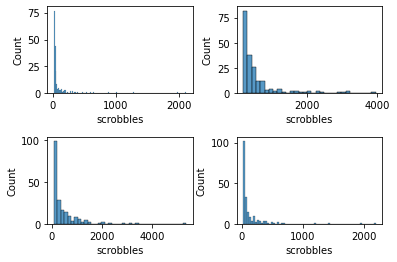

In [14]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.5, wspace=0.3)
ax = fig.add_subplot(2,2,1)
ax.set_xlabel("scrobbles")
sns.histplot(scrobsM[1].data,ax=ax)
for i in range(2,5):
    ax = fig.add_subplot(2, 2, i)
    ax.set_xlabel("scrobbles")
    sns.histplot(scrobsM[i+11].data, ax=ax)

plt.show()

### User Normalization

To make users comparable, we can normalize by each user's maximum and mean

While we're at it, lets drop any users who could not rank their preferences (those with only 1 artist listened to, only 1 listen per artist)

In [15]:
uscrobs = scrobsdf.groupby("user_id").scrobbles
umin = uscrobs.transform('min').to_numpy()
umax = uscrobs.transform('max').to_numpy()

badusers2 = scrobsdf.iloc[(umax-umin) == 0].user_id.unique()
scrobsdf = scrobsdf[~scrobsdf.user_id.isin(badusers2)]

uscrobs = scrobsdf.groupby("user_id").scrobbles
umin = uscrobs.transform('min').to_numpy()
umax = uscrobs.transform('max').to_numpy()

In [16]:
umax = uscrobs.transform('max').to_numpy()
umean = uscrobs.transform('mean').to_numpy()

scrobsdf["norm"] = (scrobsdf.scrobbles)/(umax+umean)

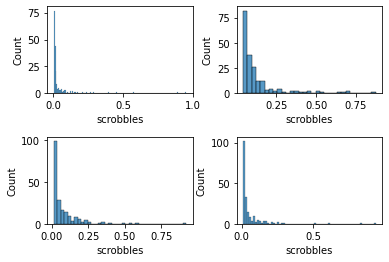

In [17]:
scrobsM = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
scrobsM[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf["norm"]
scrobsM = scrobsM.tocsr()

fig = plt.figure()
fig.subplots_adjust(hspace=0.5, wspace=0.3)
ax = fig.add_subplot(2,2,1)
ax.set_xlabel("scrobbles")
sns.histplot(scrobsM[1].data,ax=ax)
for i in range(2,5):
    ax = fig.add_subplot(2, 2, i)
    ax.set_xlabel("scrobbles")
    sns.histplot(scrobsM[i+11].data, ax=ax)

plt.show()

In [19]:
scrobsdf.norm.describe()

count    281015.000000
mean          0.060236
std           0.112885
min           0.000023
25%           0.007807
50%           0.023554
75%           0.062309
max           0.993834
Name: norm, dtype: float64

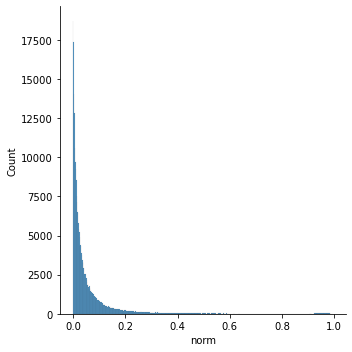

In [20]:
sns.displot(scrobsdf["norm"])

### Converting to ratings

This is great, now our users are comparable and the overall shape of the dataset seems to have been preserved, but these aren't representative scores. As this data only contains the top 50 artists of the user, each artist should receive a decently high rating. We can shift everything over with a log transformation with a chosen epsilon

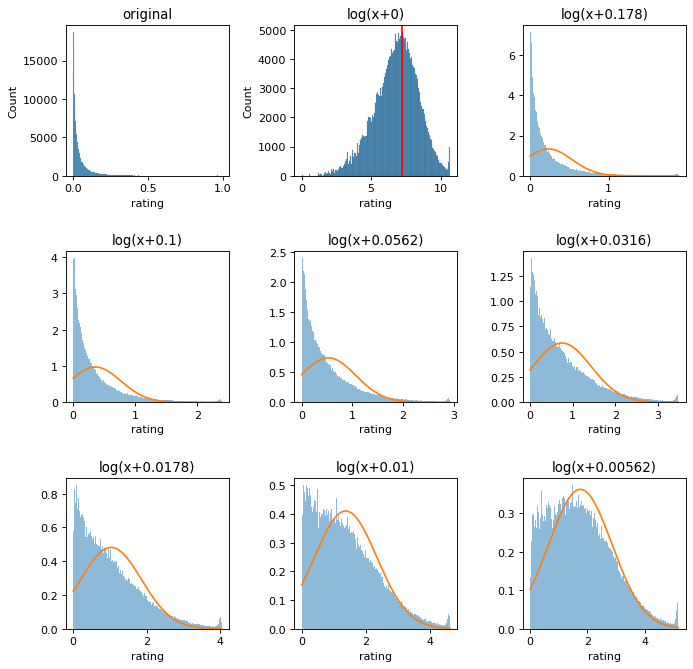

In [22]:
ratgraphs(scrobsdf, "norm")

We aren't looking for a normal distribution, as our data is cut off artifically at 50 artists, so we should find what looks like the right half of a normal distribution (minus that lip on the right representing favorite artists). This is where a judgement call must be made, as it's hard to say if 50 artists is enough to encapsulate scores below your most common. It is also hard to say if your 50th ranked artist should receive a rather good or a rather bad score. If your data was collected over a few years, 50 artists could receive pretty high scores, whereas if you have only been collecting data for a year or less, only the top of your top 50 should have good scores. This is where we can incorporate a weight based on the total number of listens a user has.

In [23]:
scrobsdf["rating"] = np.log(scrobsdf.norm+0.006)
scrobsdf.rating += abs(min(scrobsdf.rating))

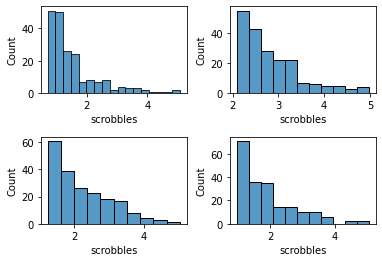

In [24]:
ugraphs(scrobsdf, "rating")

In [25]:
scrobsdf = recalc_ratings()

ValueError: operands could not be broadcast together with shapes (92761,) (281015,) 

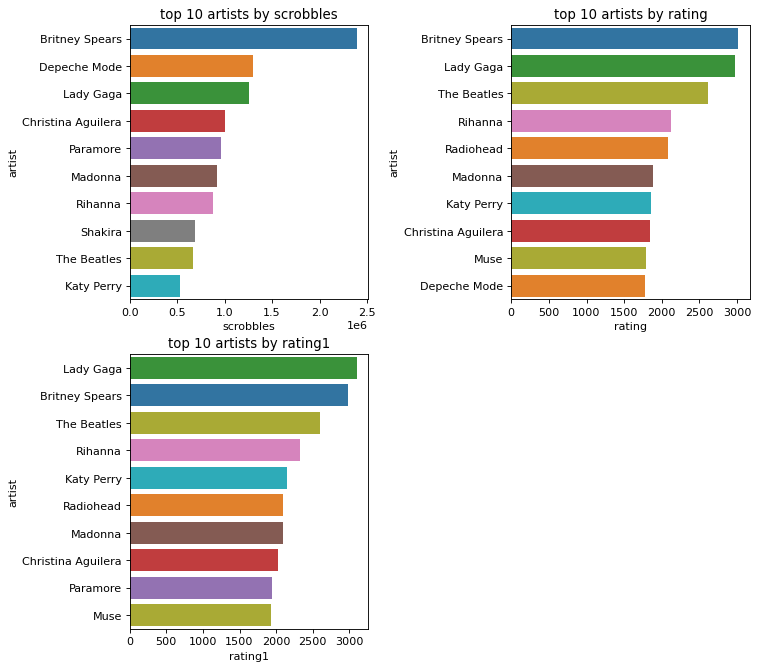

In [258]:
artgraphs(scrobsdf)

In [256]:
scrobsdf[scrobsdf.user_id == 12][["scrobbles", "rating", "rating1", "artist_name"]]

,scrobbles,rating,rating1,artist_name
549,3967,9.998854,8.415879,Lady Gaga
550,38,0.773162,0.675533,Avril Lavigne
551,17,0.371733,0.341663,Nelly Furtado
552,16,0.351128,0.324542,Lily Allen
553,12,0.267183,0.254805,David Guetta
554,10,0.224262,0.219159,Lindsay Lohan
555,9,0.202557,0.201136,Madonna
556,9,0.202557,0.201136,P!Nk
557,8,0.180684,0.182975,Jeffree Star
558,6,0.136428,0.146236,Gwen Stefani


,scrobbles,rating,rating1,artist_name
0,13883,9.458025,4.584049,Duran Duran
1,11690,8.988133,4.430390,Morcheeba
2,11351,8.908034,4.404105,Air
3,10300,8.644316,4.317357,Hooverphonic
4,8983,8.275087,4.195314,Kylie Minogue
5,6152,7.268834,3.858385,Daft Punk
6,5955,7.183561,3.829481,Thievery Corporation
7,4616,6.524370,3.603707,Goldfrapp
8,4337,6.365438,3.548572,New Order
9,4147,6.251887,3.508990,Matt Bianco


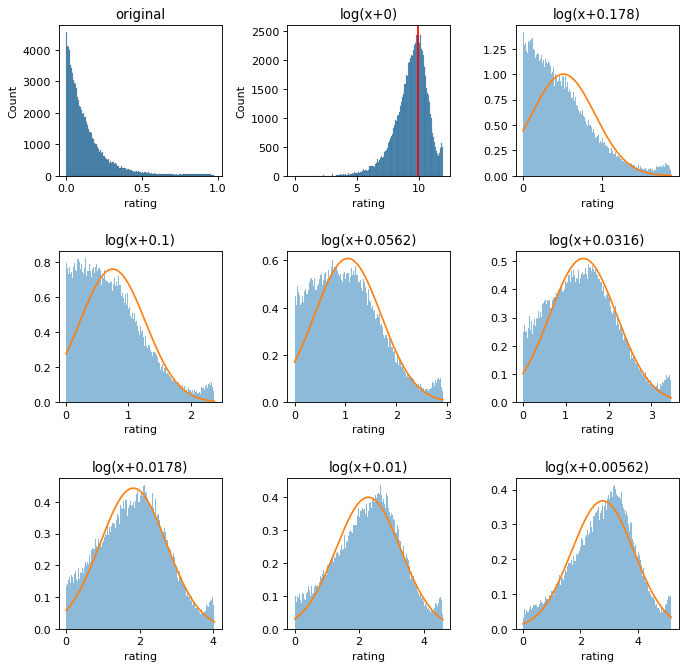

In [217]:
ratgraphs(scrobsdf, "norm")

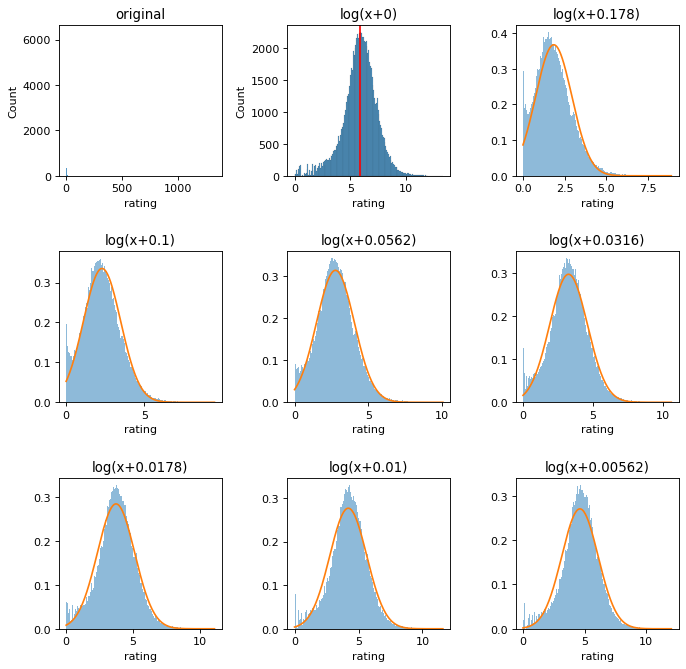

In [216]:
ratgraphs(scrobsdf, "norm1")

In [108]:
# toy = np.array([i for i in range(20)])
# toy
umed = uscrobs.transform('median').to_numpy()

scrobsdf = recalc_ratings()

us = scrobsdf.groupby("user_id")
med = scrobsdf.scrobbles.median()
adjust = (us.scrobbles.median()/med) # describes if user's top 50 shouold be highly rated, high -> overall high scores, low -> overall average scores
spread = us.scrobbles.max()/us.scrobbles.median() # describes the desired spread of a user's scores, high -> big top low bottom score, low -> close together

user_id
1       9.190385
2       0.369231
3       1.394231
4       0.775000
5       0.065385
          ...   
1888    0.275000
1889    2.832692
1890    0.557692
1891    0.523077
1892    2.051923
Name: scrobbles, Length: 1881, dtype: float64

In [130]:
usc = scrobsdf[scrobsdf.user_id == 33].scrobbles
usc.median()/med
scrobsdf[scrobsdf.user_id == 2]

,user_id,artist_id,scrobbles,norm,rating
50,2,11634,13176,0.922271,3.457566
51,2,12897,662,0.046338,0.933881
52,2,9660,493,0.034508,0.765508
53,2,2799,431,0.030168,0.695863
54,2,11600,403,0.028209,0.662747
55,2,11637,354,0.024779,0.602017
56,2,2503,269,0.018829,0.487040
57,2,9261,236,0.016519,0.438579
58,2,942,215,0.015049,0.406471
59,2,3818,215,0.015049,0.406471


In [ ]:
# scrobsdf["rating"] = np.log((scrobsdf.scrobbles - umin) / (umax - umin))

In [ ]:
# scrobsdf["rating_sum"] = np.log(scrobsdf.scrobbles / usum) + 12

Drop users who havent' listened to a range of artists

In [ ]:
scrobsM = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
scrobsM[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf["rating"]
scrobsM = scrobsM.tocsr()

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.5, wspace=0.3)
ax = fig.add_subplot(2,2,1)
ax.set_xlabel("scrobbles norm")
sns.histplot(scrobsM[1].data,ax=ax)
for i in range(2,5):
    ax = fig.add_subplot(2, 2, i)
    ax.set_xlabel("scrobbles norm")
    sns.histplot(scrobsM[i+11].data, ax=ax)

plt.show()

In [ ]:
df = pd.read_csv("./data/lastfm_user_scrobbles.csv")
artdf = pd.read_csv("./data/lastfm_artist_list.csv")
artdf = artdf.set_index("artist_id")
artists = artdf.to_numpy().flatten()
artists = np.insert(artists,0,'___empty___')
df.scrobbles.describe()

In [260]:
data = [[5, 7], [7, 3], [8, 1]]
ctys = ['Boston', 'Phoenix', 'New York']
df = pd.DataFrame(data, columns=['xcord', 'ycord'], index=ctys)
df.values

array([[5, 7],
       [7, 3],
       [8, 1]], dtype=int64)

In [ ]:
def unskew(scrobs): 
    denom_max = np.repeat(scrobs.max(axis=1).A, scrobs.getnnz(axis=1))
    denom_min = np.repeat(scrobs.min(axis=1).A, scrobs.getnnz(axis=1)) # incorrect, gives 0, we want non-zero minimum
    return (scrobs.data - denom_min)/(denom_max - denom_min)
# scrobs.data = unskew(scrobs)

In [ ]:
scrobsdf = pd.read_csv("./data/lastfm_user_scrobbles.csv")
df=scrobsdf
# df["artist"] = artdf.loc[df["artist_id"].to_numpy()]["artist_name"].to_numpy()
# df["rating"] = (df.scrobbles) / df.groupby("user_id").scrobbles.transform('max').to_numpy()
scrobmin = df.groupby("user_id").scrobbles.transform('min').to_numpy()
scrobmax = df.groupby("user_id").scrobbles.transform('max').to_numpy()
scrobsum = df.groupby("user_id").scrobbles.transform('sum').to_numpy()
scrobsmean = df.groupby("user_id").scrobbles.transform('mean').to_numpy()

df["rating"] = (df.scrobbles) / (scrobmax+scrobsmean)
# df["rating"] = df.scrobbles/scrobsum

In [ ]:
for i in range(10):
    print(0.1**i)
    eps = 0.1**i
    newrating = (np.log(df.rating+eps))# + 12

    newrating += abs(newrating.min())

    newrating = pd.DataFrame(newrating)
    print(newrating.describe())
    sns.displot(newrating)


In [259]:
scrobs = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
scrobs[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf["scrobbles"]
scrobs = scrobs.tocsr()
top50_scrobbled = artists[(scrobs.sum(axis=0)).A[0].argsort()[::-1]][:50]

NameError: name 'artists' is not defined

In [246]:
ratings = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
ratings[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf["norm"]
ratings = ratings.tocsr()
top50_rated = artists[(ratings.sum(axis=0)).A[0].argsort()[::-1]][:50]

NameError: name 'artists' is not defined

In [245]:
pd.DataFrame(np.array([top50_rated, top50_scrobbled]).T, columns=["rating", "#listens"])

NameError: name 'top50_rated' is not defined

In [ ]:
scrobsdf = pd.read_csv("./data/lastfm_user_scrobbles.csv")
scrobs = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
scrobs[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf["scrobbles"]
scrobs = scrobs.tocsr()
# scrobs.sum(axis=1)
scrobs.min(axis=1).A

In [ ]:
scrobsdf = pd.read_csv("./data/lastfm_user_scrobbles.csv")
scrobs = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
scrobs[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf["scrobbles"]
scrobs = scrobs.tocsr()

def unskew(scrobs):
#     denom_max = np.repeat(scrobs.sum(axis=1).A, scrobs.getnnz(axis=1))
#     return scrobs.data/denom_max
    
    denom_max = np.repeat(scrobs.max(axis=1).A, scrobs.getnnz(axis=1))
    denom_min = np.repeat(scrobs.min(axis=1).A, scrobs.getnnz(axis=1)) # incorrect, gives 0, we want non-zero minimum
    return (scrobs.data - denom_min)/(denom_max - denom_min)

scrobs.data = unskew(scrobs)
# scrobs.data=np.log(scrobs.data) + 12
# print(pd.DataFrame(scrobs.data).describe())
# sns.displot((scrobs.data))

In [ ]:
pd.DataFrame(scrobs.data).describe()

In [ ]:
scrobs.A

In [ ]:
for i in range(10):
    sns.displot(scrobs[i].data)

### Data reading

In [ ]:
scrobsdf = pd.read_csv("./data/lastfm_user_scrobbles.csv")

In [ ]:
df = scrobsdf
df.scrobbles.describe()

In [ ]:
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

In [ ]:
gmax = df.groupby("user_id").scrobbles.transform('max')
gmin = df.groupby("user_id").scrobbles.transform('min')
df.scrobbles = (df.scrobbles - gmin)/(gmax-gmin)

In [ ]:
normlog = df.scrobbles#normalize(np.log(df.scrobbles))
print(normlog.describe())
sns.displot(normlog)

In [ ]:
artdf = pd.read_csv("./data/lastfm_artist_list.csv")
artdf = artdf.set_index("artist_id")

In [ ]:
artdf[artdf["artist_name"].str.contains("ollier")]

### Make scipy csr sparse matrix from lil with users as rows and artist as column with # scrobbles as value

In [ ]:
scrobs = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
scrobs[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf["scrobbles"]
scrobs = scrobs.tocsr()

### Change #listens to ratings

This is to make collaborative filtering work, rather than values like 100, 90, 80 for the top 3 artists of a user, these would be scores representing how they might rate those artists. 

1. Divide by max
    * result: 1, .9, .8
    * ranking of a user's artists
    * 
2. Divide by sum
    * result: 0.37, 0.33, 0.29
    * proportion of total listens that artist occupies
    * users with many artists have lower ratings
    * ranking doesn't affect rating, so 

In [ ]:
pd.DataFrame(unskew(scrobs)).describe()

In [ ]:
sns.displot(np.log(scrobs.data))

In [ ]:
for i in range(10):
    sns.displot(scrobs[i].data)

### ----PLAYGROUND----

In [ ]:
artdf.loc[stats.mode(scrobs.argmax(axis=1).A.T[0]).mode[0]]

In [ ]:
# edges=[[1,2],[3,4],[1,5],[5,3]]
toy = np.array([[1,1,2,3,3], [2,3,1,1,2]])
toydata = np.array([100,10,200,300,30])
lil = sparse.lil_matrix((3,3))
lil[toy[0,:]-1,toy[1,:]-1] = toydata
csr = lil.tocsr()
csr.getnnz(axis=1)
csr.max(axis=1).A
denom = np.repeat(csr.max(axis=1).A,csr.getnnz(axis=1))
csr.data = csr.data/denom
len(csr.data)

In [ ]:
csr.data[csr.data < 1] = 0
len(csr.data)
csr.eliminate_zeros()
csr.data